## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #有多个GPU时可以指定只使用第几号GPU
config = tf.ConfigProto()
config.allow_soft_placement=True #允许动态放置张量和操作符
#config.gpu_options.per_process_gpu_memory_fraction = 0.4 #最多使用40%GPU内存
config.gpu_options.allow_growth=True   #初始化时不全部占满GPU显存, 按需分配 
sess = tf.Session(config = config)
set_session(sess)

Using TensorFlow backend.


In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import Dropout
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], batch_flag=True, dropout_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if dropout_ratio != 0:
                x = Dropout(dropout_ratio)(x)
                
            if batch_flag:
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            if dropout_ratio != 0:
                x = Dropout(dropout_ratio)(x)
              
            if batch_flag:
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
  

In [0]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 512
MOMENTUM = 0.95
DROP_RATIO = [0,0.2,0.4,0.6]
BATCH_FLAG = [True, False]

In [15]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch_flag in BATCH_FLAG:
    print("Experiment batch flag with Regulizer = %.6f" % (batch_flag))
    
    for ratio in DROP_RATIO:
        print("Experiment DROP RATIO with Regulizer = %.6f" % (ratio))  
    
        keras.backend.clear_session() # 把舊的 Graph 清掉

        model = build_mlp(input_shape=x_train.shape[1:], batch_flag=batch_flag, dropout_ratio=ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "exp-{}-{}".format(str(batch_flag), str(ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment batch flag with Regulizer = 1.000000
Experiment DROP RATIO with Regulizer = 0.000000


W0729 12:13:57.278401 140563356682112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0729 12:14:47.539227 140563356682112 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Experiment DROP RATIO with Regulizer = 0.200000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch

W0729 12:16:30.555299 140563356682112 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0729 12:16:30.654062 140563356682112 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Experiment DROP RATIO with Regulizer = 0.600000


W0729 12:16:30.754741 140563356682112 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

W0729 12:19:27.108559 140563356682112 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0729 12:19:27.137526 140563356682112 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Experiment DROP RATIO with Regulizer = 0.600000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)         

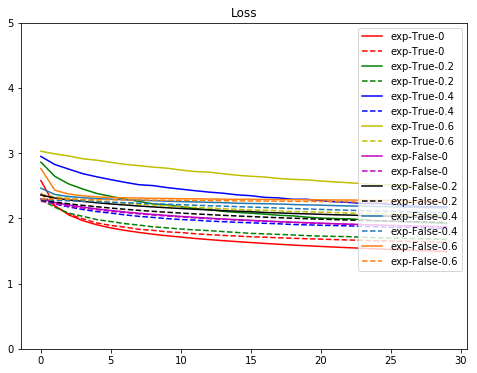

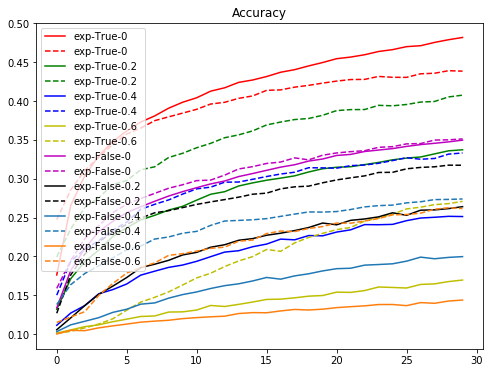

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "C0", "C1", "C2", "C3", "C4", "C5"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()